In [1]:
!nvidia-smi

Wed Feb 28 22:00:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.05              Driver Version: 545.84       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:01:00.0  On |                  Off |
|  0%   46C    P8              24W / 450W |    554MiB / 24564MiB |      7%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import numpy as np
import pandas as pd
import os
import random
import torch
from configs.configs import Configs
from models.predictor_model import EssayScorer
from transformers import AutoConfig
from utils.create_embedding_feautres import create_embedding_features
from utils.dvrl_utils import remove_top_p_sample, fit_func, pred_func, calc_qwk, random_remove_sample
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
test_prompt_id = 8
# output_path = f'outputs/DVRL_DomainAdaptation/'
output_path = f'outputs/DVRL_DomainAdaptation{test_prompt_id}/'

seed = 12
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
configs = Configs()
attribute_name = 'score'

# Load data
data_path = configs.DATA_PATH3 + str(test_prompt_id) + '/'
model_name = 'microsoft/deberta-v3-large'

cuda


load data from data/cross_prompt_attributes/8/...
Loading embedding from cache...
X_train:  (10414, 1024)
Y_train:  (10414,)
Y_train max:  1.0
Y_train min:  0.0
X_test:  (651, 1024)
Y_test:  (651,)
Y_test max:  1.0
Y_test min:  0.16666666666666666
Creating predictor model...
QWK: 0.3097
Creating predictor model...
QWK: 0.4681
Creating predictor model...
QWK: 0.3200
Creating predictor model...
QWK: 0.2937
Creating predictor model...
QWK: 0.3168
Creating predictor model...
QWK: 0.3862
Creating predictor model...
QWK: 0.5133
Creating predictor model...
QWK: 0.3878
Creating predictor model...
QWK: 0.4739
Creating predictor model...
QWK: 0.2424
Creating predictor model...
QWK: 0.2013
Creating predictor model...
QWK: 0.2783
Creating predictor model...
QWK: 0.3719
Creating predictor model...
QWK: 0.1660
Creating predictor model...
QWK: 0.1443
Creating predictor model...
QWK: 0.2155
Creating predictor model...
QWK: 0.1125
Creating predictor model...
QWK: 0.0715
Creating predictor model...
QWK:

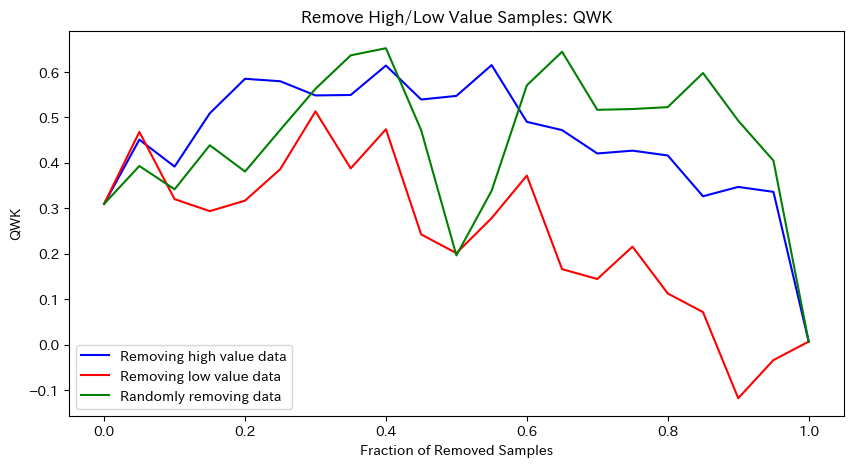

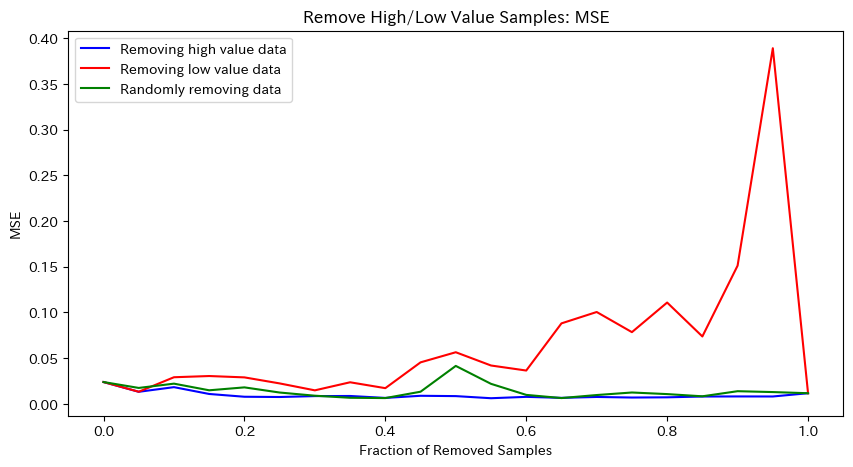

In [4]:
# train_features, _, test_features, y_train, _, y_test = create_embedding_features(data_path, test_prompt_id, attribute_name, model_name, device)
train_data, _, test_data = create_embedding_features(data_path, test_prompt_id, attribute_name, model_name, device)
train_features, test_features, y_train, y_test, id_test = train_data['essay'], test_data['essay'], train_data['normalized_label'], test_data['normalized_label'], test_data['essay_id']
dev_features, test_features, y_dev, y_test, dev_ids, _ = train_test_split(test_features, y_test, id_test, test_size=0.9, random_state=seed)

# print info
print('================================')
print('X_train: ', train_features.shape)
print('Y_train: ', y_train.shape)
print('Y_train max: ', np.max(y_train))
print('Y_train min: ', np.min(y_train))

# print('================================')
# print('X_dev: ', dev_features1.shape)
# print('Y_dev: ', y_dev1.shape)
# print('Y_dev max: ', np.max(y_dev1))
# print('Y_dev min: ', np.min(y_dev1))

print('================================')
print('X_test: ', test_features.shape)
print('Y_test: ', y_test.shape)
print('Y_test max: ', np.max(y_test))
print('Y_test min: ', np.min(y_test))
print('================================')

# Remove high and low value samples
low_qwks = []
low_mse = []
for p in np.arange(0.0, 1.01, 0.05):
    # Create predictor
    print('Creating predictor model...')
    config = AutoConfig.from_pretrained(model_name)
    pred_model = EssayScorer(config.hidden_size)

    weights = remove_top_p_sample(np.load(output_path + 'estimated_data_value.npy'), top_p=p, ascending=True)
    history = fit_func(pred_model, train_features, y_train, batch_size=256, epochs=100, device=device, sample_weight=weights)

    y_pred = pred_func(pred_model, test_features, batch_size=256, device=device)
    qwk = calc_qwk(y_test, y_pred, test_prompt_id, 'score')
    mse = mean_squared_error(y_test, y_pred)
    print(f'QWK: {qwk:.4f}')
    low_qwks.append(qwk)
    low_mse.append(mse)

np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

high_qwks = []
high_mse = []
for p in np.arange(0.0, 1.01, 0.05):
    # Create predictor
    print('Creating predictor model...')
    config = AutoConfig.from_pretrained(model_name)
    pred_model = EssayScorer(config.hidden_size)

    weights = remove_top_p_sample(np.load(output_path + 'estimated_data_value.npy'), top_p=p, ascending=False)
    history = fit_func(pred_model, train_features, y_train, batch_size=256, epochs=100, device=device, sample_weight=weights)

    y_pred = pred_func(pred_model, test_features, batch_size=256, device=device)
    qwk = calc_qwk(y_test, y_pred, test_prompt_id, 'score')
    mse = mean_squared_error(y_test, y_pred)
    print(f'QWK: {qwk:.4f}')
    high_qwks.append(qwk)
    high_mse.append(mse)


np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

random_qwks = []
random_mse = []
for p in np.arange(0.0, 1.01, 0.05):
    # Create predictor
    print('Creating predictor model...')
    config = AutoConfig.from_pretrained(model_name)
    pred_model = EssayScorer(config.hidden_size)

    weights = random_remove_sample(np.load(output_path + 'estimated_data_value.npy'), remove_p=p)
    history = fit_func(pred_model, train_features, y_train, batch_size=256, epochs=100, device=device, sample_weight=weights)

    y_pred = pred_func(pred_model, test_features, batch_size=256, device=device)
    qwk = calc_qwk(y_test, y_pred, test_prompt_id, 'score')
    mse = mean_squared_error(y_test, y_pred)
    print(f'QWK: {qwk:.4f}')
    random_qwks.append(qwk)
    random_mse.append(mse)

# plot
p = np.arange(0.0, 1.01, 0.05)
plt.figure(figsize=(10, 5))
plt.plot(p, high_qwks, label='Removing high value data', color='blue')
plt.plot(p, low_qwks, label='Removing low value data', color='red')
plt.plot(p, random_qwks, label='Randomly removing data', color='green')
plt.title('Remove High/Low Value Samples: QWK')
plt.xlabel('Fraction of Removed Samples')
plt.ylabel('QWK')
plt.legend()
plt.savefig(output_path + 'remove_high_low_samples_qwk.png')

plt.figure(figsize=(10, 5))
plt.plot(p, high_mse, label='Removing high value data', color='blue')
plt.plot(p, low_mse, label='Removing low value data', color='red')
plt.plot(p, random_mse, label='Randomly removing data', color='green')
plt.title('Remove High/Low Value Samples: MSE')
plt.xlabel('Fraction of Removed Samples')
plt.ylabel('MSE')
plt.legend()
plt.savefig(output_path + 'remove_high_low_samples_mse.png')

In [5]:
data_values = np.load(output_path + 'estimated_data_value.npy')

In [6]:
data_values.mean()

0.6675971

In [7]:
data_values.max()

0.6694559

In [8]:
data_values.min()

0.66692775

### 訓練に使用したテストデータのみを用いて学習する

In [9]:
from utils.create_embedding_feautres import load_data, normalize_scores, create_data_loader
from transformers import AutoTokenizer, AutoModel, AutoConfig

In [10]:
data = load_data(data_path)

features = np.array(data['test']['feature'])
labels = np.array(data['test']['label'])
prompts = np.array(data['test']['essay_set'])
ids = np.array(data['test']['essay_id'])
# Normalize scores
normalized_labels = normalize_scores(labels, prompts, attribute_name)


train_id = np.load(output_path + 'dev_ids.npy')

In [11]:
train_data = {}
test_data = {}

idx = np.where(np.isin(ids, train_id))
test_idx = np.where(np.isin(ids, train_id, invert=True))
train_data['feature'] = features[idx]
train_data['normalized_label'] = normalized_labels[idx]
train_data['essay_set'] = prompts[idx]

test_data['feature'] = features[test_idx]
test_data['normalized_label'] = normalized_labels[test_idx]
test_data['essay_set'] = prompts[test_idx]

print(train_data['feature'].shape)
print(test_data['feature'].shape)

(72,)
(651,)


In [12]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from utils.evaluation import train_epoch, evaluate_epoch


model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)
config = AutoConfig.from_pretrained(model_name)

train_loader = create_data_loader(train_data, tokenizer, max_length=512, batch_size=32)
test_loader = create_data_loader(test_data, tokenizer, max_length=512, batch_size=32)

# set parameters
EPOCHS = 20

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('mps')
print(f"Using {device}")

# Define the model
class PreTrainedScorer(nn.Module):
    def __init__(self, base_model: AutoModel, hidden_size=768, num_labels=1):
        super(PreTrainedScorer, self).__init__()
        self.base_model = base_model
        self.regressor = nn.Linear(hidden_size, num_labels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.regressor(pooled_output)
        return self.sigmoid(logits)

# Initialize the model
model = PreTrainedScorer(model, hidden_size=config.hidden_size).to(device)

# Define loss function, optimizer, and scheduler
loss_fn = nn.MSELoss(reduction='none').to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*EPOCHS)

# Training loop
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")

    # Training Set
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler, use_weight=False)
    print(f"Training loss: {train_loss}")

    # Test Set
    eval_history = evaluate_epoch(model, test_loader, loss_fn, device, attribute_name)
    print(f"Test loss: {eval_history['loss']:.4f}")

    print(f'[TEST] -> QWK: {eval_history["qwk"]: .3f}, CORR: {eval_history["corr"]: .3f}, RMSE: {eval_history["rmse"]: .3f}')

best_val_metrics = [eval_history[met] for met in ['qwk', 'lwk', 'corr', 'rmse', 'mae']]

pd.DataFrame(np.array(best_val_metrics).reshape(1, 5), columns=['qwk', 'lwk', 'corr', 'rmse', 'mae']).to_csv(output_path + f'baseline_metrics{test_prompt_id}.csv', index=False, header=True)

/home/takumi/anaconda3/envs/torch/lib/python3.10/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Using cuda
Epoch 1/20


Training: 100%|███████████████████████████████████████| 3/3 [00:01<00:00,  1.68batch/s, loss=0.0235]


Training loss: 0.02352653630077839


Evaluation: 100%|██████████████████████████████████| 21/21 [00:02<00:00,  7.35batch/s, loss=0.00896]


[0.1874477]
Test loss: 0.0090
[TEST] -> QWK:  0.187, CORR:  0.294, RMSE:  0.093
Epoch 2/20


Training: 100%|██████████████████████████████████████| 3/3 [00:00<00:00,  3.28batch/s, loss=0.00645]


Training loss: 0.006445692852139473


Evaluation: 100%|███████████████████████████████████| 21/21 [00:02<00:00,  7.43batch/s, loss=0.0107]


[0.21641484]
Test loss: 0.0107
[TEST] -> QWK:  0.216, CORR:  0.440, RMSE:  0.103
Epoch 3/20


Training: 100%|██████████████████████████████████████| 3/3 [00:00<00:00,  3.24batch/s, loss=0.00392]


Training loss: 0.003923098789528012


Evaluation: 100%|██████████████████████████████████| 21/21 [00:02<00:00,  7.51batch/s, loss=0.00748]


[0.29522952]
Test loss: 0.0075
[TEST] -> QWK:  0.295, CORR:  0.522, RMSE:  0.086
Epoch 4/20


Training: 100%|████████████████████████████████████████| 3/3 [00:00<00:00,  3.27batch/s, loss=0.004]


Training loss: 0.003995467132578294


Evaluation: 100%|██████████████████████████████████| 21/21 [00:02<00:00,  7.50batch/s, loss=0.00703]


[0.33240452]
Test loss: 0.0070
[TEST] -> QWK:  0.332, CORR:  0.584, RMSE:  0.083
Epoch 5/20


Training: 100%|███████████████████████████████████████| 3/3 [00:00<00:00,  3.20batch/s, loss=0.0032]


Training loss: 0.0032009874703362584


Evaluation: 100%|██████████████████████████████████| 21/21 [00:02<00:00,  7.33batch/s, loss=0.00715]


[0.38438149]
Test loss: 0.0072
[TEST] -> QWK:  0.384, CORR:  0.637, RMSE:  0.084
Epoch 6/20


Training: 100%|██████████████████████████████████████| 3/3 [00:00<00:00,  3.29batch/s, loss=0.00254]


Training loss: 0.002543750607098142


Evaluation: 100%|██████████████████████████████████| 21/21 [00:02<00:00,  7.44batch/s, loss=0.00682]


[0.42217422]
Test loss: 0.0068
[TEST] -> QWK:  0.422, CORR:  0.657, RMSE:  0.082
Epoch 7/20


Training: 100%|██████████████████████████████████████| 3/3 [00:00<00:00,  3.28batch/s, loss=0.00222]


Training loss: 0.002220246746825675


Evaluation: 100%|██████████████████████████████████| 21/21 [00:02<00:00,  7.49batch/s, loss=0.00618]


[0.46029222]
Test loss: 0.0062
[TEST] -> QWK:  0.460, CORR:  0.663, RMSE:  0.078
Epoch 8/20


Training: 100%|██████████████████████████████████████| 3/3 [00:00<00:00,  3.23batch/s, loss=0.00207]


Training loss: 0.00207458254105101


Evaluation: 100%|██████████████████████████████████| 21/21 [00:02<00:00,  7.50batch/s, loss=0.00593]


[0.48723794]
Test loss: 0.0059
[TEST] -> QWK:  0.487, CORR:  0.669, RMSE:  0.076
Epoch 9/20


Training: 100%|██████████████████████████████████████| 3/3 [00:00<00:00,  3.24batch/s, loss=0.00157]


Training loss: 0.0015704134129919112


Evaluation: 100%|██████████████████████████████████| 21/21 [00:02<00:00,  7.47batch/s, loss=0.00585]


[0.51301009]
Test loss: 0.0058
[TEST] -> QWK:  0.513, CORR:  0.676, RMSE:  0.076
Epoch 10/20


Training: 100%|██████████████████████████████████████| 3/3 [00:00<00:00,  3.28batch/s, loss=0.00139]


Training loss: 0.0013926419390675922


Evaluation: 100%|██████████████████████████████████| 21/21 [00:02<00:00,  7.50batch/s, loss=0.00571]


[0.52919501]
Test loss: 0.0057
[TEST] -> QWK:  0.529, CORR:  0.678, RMSE:  0.075
Epoch 11/20


Training: 100%|██████████████████████████████████████| 3/3 [00:00<00:00,  3.24batch/s, loss=0.00115]


Training loss: 0.001149396732216701


Evaluation: 100%|██████████████████████████████████| 21/21 [00:02<00:00,  7.48batch/s, loss=0.00554]


[0.54647447]
Test loss: 0.0055
[TEST] -> QWK:  0.546, CORR:  0.676, RMSE:  0.074
Epoch 12/20


Training: 100%|██████████████████████████████████████| 3/3 [00:00<00:00,  3.17batch/s, loss=0.00105]


Training loss: 0.0010536096039383362


Evaluation: 100%|██████████████████████████████████| 21/21 [00:02<00:00,  7.46batch/s, loss=0.00548]


[0.55353692]
Test loss: 0.0055
[TEST] -> QWK:  0.554, CORR:  0.676, RMSE:  0.073
Epoch 13/20


Training: 100%|█████████████████████████████████████| 3/3 [00:00<00:00,  3.29batch/s, loss=0.000978]


Training loss: 0.000977708831972753


Evaluation: 100%|██████████████████████████████████| 21/21 [00:02<00:00,  7.32batch/s, loss=0.00554]


[0.56018629]
Test loss: 0.0055
[TEST] -> QWK:  0.560, CORR:  0.677, RMSE:  0.074
Epoch 14/20


Training: 100%|█████████████████████████████████████| 3/3 [00:00<00:00,  3.24batch/s, loss=0.000929]


Training loss: 0.0009286717201272646


Evaluation: 100%|██████████████████████████████████| 21/21 [00:02<00:00,  7.42batch/s, loss=0.00566]


[0.56779633]
Test loss: 0.0057
[TEST] -> QWK:  0.568, CORR:  0.678, RMSE:  0.075
Epoch 15/20


Training: 100%|█████████████████████████████████████| 3/3 [00:00<00:00,  3.26batch/s, loss=0.000792]


Training loss: 0.0007916520698927343


Evaluation: 100%|██████████████████████████████████| 21/21 [00:02<00:00,  7.47batch/s, loss=0.00551]


[0.57393694]
Test loss: 0.0055
[TEST] -> QWK:  0.574, CORR:  0.676, RMSE:  0.074
Epoch 16/20


Training: 100%|██████████████████████████████████████| 3/3 [00:00<00:00,  3.17batch/s, loss=0.00069]


Training loss: 0.0006901364201136554


Evaluation: 100%|██████████████████████████████████| 21/21 [00:02<00:00,  7.27batch/s, loss=0.00544]


[0.57512257]
Test loss: 0.0054
[TEST] -> QWK:  0.575, CORR:  0.675, RMSE:  0.073
Epoch 17/20


Training: 100%|█████████████████████████████████████| 3/3 [00:00<00:00,  3.22batch/s, loss=0.000637]


Training loss: 0.0006370447711863866


Evaluation: 100%|██████████████████████████████████| 21/21 [00:02<00:00,  7.36batch/s, loss=0.00544]


[0.58005337]
Test loss: 0.0054
[TEST] -> QWK:  0.580, CORR:  0.675, RMSE:  0.073
Epoch 18/20


Training: 100%|█████████████████████████████████████| 3/3 [00:00<00:00,  3.22batch/s, loss=0.000747]


Training loss: 0.0007466641448748609


Evaluation: 100%|██████████████████████████████████| 21/21 [00:02<00:00,  7.47batch/s, loss=0.00546]


[0.5805768]
Test loss: 0.0055
[TEST] -> QWK:  0.581, CORR:  0.675, RMSE:  0.073
Epoch 19/20


Training: 100%|█████████████████████████████████████| 3/3 [00:00<00:00,  3.26batch/s, loss=0.000646]


Training loss: 0.0006461038768369084


Evaluation: 100%|██████████████████████████████████| 21/21 [00:02<00:00,  7.43batch/s, loss=0.00546]


[0.57992541]
Test loss: 0.0055
[TEST] -> QWK:  0.580, CORR:  0.675, RMSE:  0.073
Epoch 20/20


Training: 100%|██████████████████████████████████████| 3/3 [00:00<00:00,  3.22batch/s, loss=0.00056]


Training loss: 0.0005597561103058979


Evaluation: 100%|██████████████████████████████████| 21/21 [00:02<00:00,  7.46batch/s, loss=0.00546]

[0.58014311]
Test loss: 0.0055
[TEST] -> QWK:  0.580, CORR:  0.676, RMSE:  0.073


## 選ばれたデータを用いて，別モデルを学習 (BERT)

In [13]:
逆張り = True

In [14]:
from utils.create_embedding_feautres import load_data, normalize_scores, create_data_loader
from transformers import AutoTokenizer, AutoModel, AutoConfig
import collections

In [15]:
data = load_data(data_path)
data_values = np.load(output_path + 'estimated_data_value.npy')
if 逆張り:
    weights = remove_top_p_sample(data_values, top_p=0.9, ascending=False)
else:
    weights = remove_top_p_sample(data_values, top_p=0.9, ascending=True)

y_train = np.array(data['train']['label'])
y_dev = np.array(data['dev']['label'])
y_test = np.array(data['test']['label'])

train_essay_prompt = np.array(data['train']['essay_set'])
dev_essay_prompt = np.array(data['dev']['essay_set'])
test_essay_prompt = np.array(data['test']['essay_set'])

# Normalize scores
y_train = normalize_scores(y_train, train_essay_prompt, attribute_name)
y_dev = normalize_scores(y_dev, dev_essay_prompt, attribute_name)
y_test = normalize_scores(y_test, test_essay_prompt, attribute_name)

data['train']['normalized_label'] = y_train
data['dev']['normalized_label'] = y_dev
data['test']['normalized_label'] = y_test

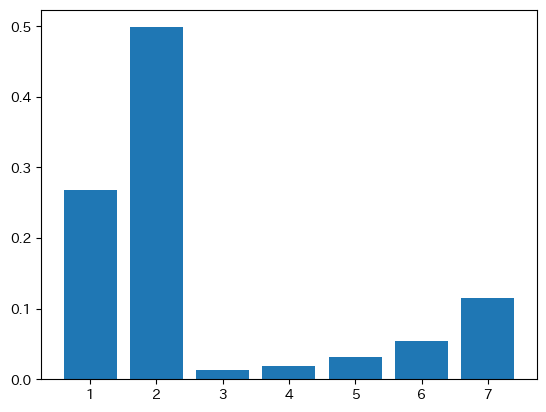

In [16]:
if 逆張り:
    top10per_list = train_essay_prompt[data_values.flatten().argsort()][:int(len(data_values)*0.1)]
else:
    top10per_list = train_essay_prompt[data_values.flatten().argsort()[::-1]][:int(len(data_values)*0.1)]
count = collections.Counter(top10per_list)
plt.bar(list(count.keys()), [i / len(top10per_list) for i in list(count.values())])
plt.savefig(output_path + 'high_value_prompt.png')

In [17]:
for key, value in dict(count).items():
    count[key] = value / len(top10per_list)

In [18]:
avg_weight_dict = dict((x, y) for x, y in sorted(count.items()))
avg_weight_dict

{1: 0.2680115273775216,
 2: 0.49855907780979825,
 3: 0.012487992315081652,
 4: 0.01921229586935639,
 5: 0.03170028818443804,
 6: 0.05475504322766571,
 7: 0.11527377521613832}

In [19]:
avg_weight_list = [v for k, v in avg_weight_dict.items()]
avg_weight_list

[0.2680115273775216,
 0.49855907780979825,
 0.012487992315081652,
 0.01921229586935639,
 0.03170028818443804,
 0.05475504322766571,
 0.11527377521613832]

In [20]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from utils.evaluation import train_epoch, evaluate_epoch


model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)
config = AutoConfig.from_pretrained(model_name)

train_loader = create_data_loader(data['train'], tokenizer, max_length=512, batch_size=32, weights=weights)
dev_loader = create_data_loader(data['dev'], tokenizer, max_length=512, batch_size=32)
test_loader = create_data_loader(data['test'], tokenizer, max_length=512, batch_size=32)

# set parameters
EPOCHS = 10

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('mps')
print(f"Using {device}")

# Define the model
class PreTrainedScorer(nn.Module):
    def __init__(self, base_model: AutoModel, hidden_size=768, num_labels=1):
        super(PreTrainedScorer, self).__init__()
        self.base_model = base_model
        self.regressor = nn.Linear(hidden_size, num_labels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.regressor(pooled_output)
        return self.sigmoid(logits)

# Initialize the model
model = PreTrainedScorer(model, hidden_size=config.hidden_size).to(device)

# Define loss function, optimizer, and scheduler
loss_fn = nn.MSELoss(reduction='none').to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*EPOCHS)

# Training loop
best_test_metrics = [-1, -1, -1, -1, -1]
best_val_metrics = [-1, -1, -1, -1, -1]
best_test = [-1, -1, -1, -1, -1]
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")

    # Training Set
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler)
    print(f"Training loss: {train_loss}")

    # Development Set
    dev_history = evaluate_epoch(model, dev_loader, loss_fn, device, attribute_name, avg_weight_list)
    print(f"Dev loss: {dev_history['loss']:.4f}")

    # Test Set
    eval_history = evaluate_epoch(model, test_loader, loss_fn, device, attribute_name)
    print(f"Test loss: {eval_history['loss']:.4f}")

    print(f'[VAL]  -> QWK: {dev_history["qwk"]: .3f}, CORR: {dev_history["corr"]: .3f}, RMSE: {dev_history["rmse"]: .3f}')
    print(f'[TEST] -> QWK: {eval_history["qwk"]: .3f}, CORR: {eval_history["corr"]: .3f}, RMSE: {eval_history["rmse"]: .3f}')

    if dev_history["qwk"] > best_val_metrics[0]:
        for i, met in enumerate(['qwk', 'lwk', 'corr', 'rmse', 'mae']):
            best_val_metrics[i] = dev_history[met]
            best_test_metrics[i] = eval_history[met]
    if eval_history["qwk"] > best_test[0]:
        for i, met in enumerate(['qwk', 'lwk', 'corr', 'rmse', 'mae']):
            best_test[i] = eval_history[met]

    print(f'[BEST] -> QWK: {best_test_metrics[0]: .3f}, CORR: {best_test_metrics[2]: .3f}, RMSE: {best_test_metrics[3]: .3f}')

pd.DataFrame(np.array(best_test_metrics).reshape(1, 5), columns=['qwk', 'lwk', 'corr', 'rmse', 'mae']).to_csv(output_path + f'BERT_best_metrics{test_prompt_id}.csv', index=False, header=True)
pd.DataFrame(np.array(best_test).reshape(1, 5), columns=['qwk', 'lwk', 'corr', 'rmse', 'mae']).to_csv(output_path + f'BERT_sample_metrics{test_prompt_id}.csv', index=False, header=True)

Using cuda
Epoch 1/10


Training: 100%|█████████████████████████████████| 326/326 [02:01<00:00,  2.68batch/s, loss=0.000192]


Training loss: 0.00019160517616837125


Evaluation: 100%|███████████████████████████████████| 58/58 [00:07<00:00,  7.39batch/s, loss=0.0643]


[0.5296514  0.29771763 0.15470715 0.15127105 0.33804838 0.2092238
 0.58861934]
Dev loss: 0.0643


Evaluation: 100%|██████████████████████████████████| 23/23 [00:03<00:00,  7.15batch/s, loss=0.00777]


[0.31900578]
Test loss: 0.0078
[VAL]  -> QWK:  0.385, CORR:  0.480, RMSE:  0.254
[TEST] -> QWK:  0.319, CORR:  0.426, RMSE:  0.087
[BEST] -> QWK:  0.319, CORR:  0.426, RMSE:  0.087
Epoch 2/10


Training: 100%|██████████████████████████████████| 326/326 [02:01<00:00,  2.69batch/s, loss=4.83e-5]


Training loss: 4.8303960969900844e-05


Evaluation: 100%|███████████████████████████████████| 58/58 [00:07<00:00,  7.51batch/s, loss=0.0672]


[0.5482355  0.31499544 0.10160628 0.11379853 0.33767439 0.2092238
 0.56114496]
Dev loss: 0.0672


Evaluation: 100%|██████████████████████████████████| 23/23 [00:03<00:00,  7.30batch/s, loss=0.00787]


[0.3485353]
Test loss: 0.0079
[VAL]  -> QWK:  0.394, CORR:  0.467, RMSE:  0.260
[TEST] -> QWK:  0.349, CORR:  0.436, RMSE:  0.088
[BEST] -> QWK:  0.349, CORR:  0.436, RMSE:  0.088
Epoch 3/10


Training: 100%|██████████████████████████████████| 326/326 [02:01<00:00,  2.69batch/s, loss=3.27e-5]


Training loss: 3.271940595368757e-05


Evaluation: 100%|█████████████████████████████████████| 58/58 [00:07<00:00,  7.53batch/s, loss=0.07]


[0.54645214 0.39269874 0.04683841 0.06488479 0.34069695 0.21245209
 0.52106803]
Dev loss: 0.0700


Evaluation: 100%|██████████████████████████████████| 23/23 [00:03<00:00,  7.25batch/s, loss=0.00819]


[0.33537628]
Test loss: 0.0082
[VAL]  -> QWK:  0.427, CORR:  0.460, RMSE:  0.265
[TEST] -> QWK:  0.335, CORR:  0.461, RMSE:  0.090
[BEST] -> QWK:  0.335, CORR:  0.461, RMSE:  0.090
Epoch 4/10


Training: 100%|██████████████████████████████████| 326/326 [02:01<00:00,  2.68batch/s, loss=2.38e-5]


Training loss: 2.3786976264809698e-05


Evaluation: 100%|███████████████████████████████████| 58/58 [00:07<00:00,  7.51batch/s, loss=0.0679]


[0.54339025 0.35384172 0.08923924 0.11379853 0.33767439 0.21198975
 0.54186037]
Dev loss: 0.0679


Evaluation: 100%|██████████████████████████████████| 23/23 [00:03<00:00,  7.20batch/s, loss=0.00818]


[0.32085324]
Test loss: 0.0082
[VAL]  -> QWK:  0.410, CORR:  0.487, RMSE:  0.261
[TEST] -> QWK:  0.321, CORR:  0.438, RMSE:  0.090
[BEST] -> QWK:  0.335, CORR:  0.461, RMSE:  0.090
Epoch 5/10


Training: 100%|██████████████████████████████████| 326/326 [02:01<00:00,  2.69batch/s, loss=1.48e-5]


Training loss: 1.4766043370617326e-05


Evaluation: 100%|███████████████████████████████████| 58/58 [00:07<00:00,  7.50batch/s, loss=0.0675]


[0.54394104 0.33227103 0.09540847 0.12493119 0.34069695 0.21198975
 0.55605459]
Dev loss: 0.0675


Evaluation: 100%|██████████████████████████████████| 23/23 [00:03<00:00,  7.26batch/s, loss=0.00834]


[0.31407799]
Test loss: 0.0083
[VAL]  -> QWK:  0.402, CORR:  0.496, RMSE:  0.260
[TEST] -> QWK:  0.314, CORR:  0.422, RMSE:  0.090
[BEST] -> QWK:  0.335, CORR:  0.461, RMSE:  0.090
Epoch 6/10


Training: 100%|██████████████████████████████████| 326/326 [02:01<00:00,  2.68batch/s, loss=1.56e-5]


Training loss: 1.5615111254971502e-05


Evaluation: 100%|███████████████████████████████████| 58/58 [00:07<00:00,  7.53batch/s, loss=0.0684]


[0.54927553 0.32941139 0.0974255  0.13604694 0.33430854 0.21245209
 0.55088436]
Dev loss: 0.0684


Evaluation: 100%|██████████████████████████████████| 23/23 [00:03<00:00,  7.20batch/s, loss=0.00829]


[0.31247423]
Test loss: 0.0083
[VAL]  -> QWK:  0.401, CORR:  0.490, RMSE:  0.262
[TEST] -> QWK:  0.312, CORR:  0.423, RMSE:  0.090
[BEST] -> QWK:  0.335, CORR:  0.461, RMSE:  0.090
Epoch 7/10


Training: 100%|██████████████████████████████████| 326/326 [02:01<00:00,  2.69batch/s, loss=1.32e-5]


Training loss: 1.3162546638332519e-05


Evaluation: 100%|███████████████████████████████████| 58/58 [00:07<00:00,  7.52batch/s, loss=0.0648]


[0.5377439  0.32363351 0.09120863 0.12493119 0.35069864 0.21683828
 0.56507374]
Dev loss: 0.0648


Evaluation: 100%|██████████████████████████████████| 23/23 [00:03<00:00,  7.29batch/s, loss=0.00805]


[0.31394567]
Test loss: 0.0081
[VAL]  -> QWK:  0.397, CORR:  0.504, RMSE:  0.255
[TEST] -> QWK:  0.314, CORR:  0.439, RMSE:  0.089
[BEST] -> QWK:  0.335, CORR:  0.461, RMSE:  0.090
Epoch 8/10


Training: 100%|██████████████████████████████████| 326/326 [02:01<00:00,  2.68batch/s, loss=1.03e-5]


Training loss: 1.0300204649299448e-05


Evaluation: 100%|███████████████████████████████████| 58/58 [00:07<00:00,  7.51batch/s, loss=0.0667]


[0.5438897  0.33227103 0.08923924 0.12493119 0.33729784 0.21198975
 0.55968465]
Dev loss: 0.0667


Evaluation: 100%|██████████████████████████████████| 23/23 [00:03<00:00,  7.22batch/s, loss=0.00815]


[0.31717316]
Test loss: 0.0081
[VAL]  -> QWK:  0.402, CORR:  0.487, RMSE:  0.259
[TEST] -> QWK:  0.317, CORR:  0.441, RMSE:  0.089
[BEST] -> QWK:  0.335, CORR:  0.461, RMSE:  0.090
Epoch 9/10


Training: 100%|██████████████████████████████████| 326/326 [02:01<00:00,  2.68batch/s, loss=6.56e-6]


Training loss: 6.564431212343924e-06


Evaluation: 100%|███████████████████████████████████| 58/58 [00:07<00:00,  7.50batch/s, loss=0.0657]


[0.53842905 0.31931454 0.0974255  0.12493119 0.33729784 0.21198975
 0.56745432]
Dev loss: 0.0657


Evaluation: 100%|██████████████████████████████████| 23/23 [00:03<00:00,  7.27batch/s, loss=0.00815]


[0.31265626]
Test loss: 0.0081
[VAL]  -> QWK:  0.395, CORR:  0.489, RMSE:  0.257
[TEST] -> QWK:  0.313, CORR:  0.436, RMSE:  0.089
[BEST] -> QWK:  0.335, CORR:  0.461, RMSE:  0.090
Epoch 10/10


Training: 100%|█████████████████████████████████████| 326/326 [02:02<00:00,  2.67batch/s, loss=6e-6]


Training loss: 5.995639462484616e-06


Evaluation: 100%|███████████████████████████████████| 58/58 [00:07<00:00,  7.44batch/s, loss=0.0664]


[0.5370895  0.33227103 0.08989267 0.12493119 0.33729784 0.21198975
 0.56103398]
Dev loss: 0.0664


Evaluation: 100%|███████████████████████████████████| 23/23 [00:03<00:00,  7.20batch/s, loss=0.0081]

[0.31859637]
Test loss: 0.0081
[VAL]  -> QWK:  0.400, CORR:  0.486, RMSE:  0.258
[TEST] -> QWK:  0.319, CORR:  0.444, RMSE:  0.089
[BEST] -> QWK:  0.335, CORR:  0.461, RMSE:  0.090


## 選ばれたデータを用いて，別モデルを学習 (PAES)

In [23]:
from utils.read_data import read_essays_single_score, read_pos_vocab
from utils.general_utils import get_single_scaled_down_score, pad_hierarchical_text_sequences
from torch.utils.data import TensorDataset, DataLoader
from models.PAES import PAES, fastPAES
from utils.evaluation import train_model, evaluate_model

# Load configs
configs = Configs()

data_path = configs.DATA_PATH3
print(f'load data from {data_path}...')
train_path = data_path + str(test_prompt_id) + '/train.pk'
dev_path = data_path + str(test_prompt_id) + '/dev.pk'
test_path = data_path + str(test_prompt_id) + '/test.pk'
features_path = configs.FEATURES_PATH
readability_path = configs.READABILITY_PATH
vocab_size = configs.VOCAB_SIZE
epochs = configs.EPOCHS
batch_size = configs.BATCH_SIZE

read_configs = {
    'train_path': train_path,
    'dev_path': dev_path,
    'test_path': test_path,
    'features_path': features_path,
    'readability_path': readability_path,
    'vocab_size': vocab_size
}

# Read data
pos_vocab = read_pos_vocab(read_configs)
train_data, dev_data, test_data = read_essays_single_score(read_configs, pos_vocab, attribute_name)

# Get max sentence length and max sentence number
max_sentnum = max(train_data['max_sentnum'], dev_data['max_sentnum'], test_data['max_sentnum'])
max_sentlen = max(train_data['max_sentlen'], dev_data['max_sentlen'], test_data['max_sentlen'])

# Scale down the scores
train_data['y_scaled'] = get_single_scaled_down_score(train_data['data_y'], train_data['prompt_ids'], attribute_name)
dev_data['y_scaled'] = get_single_scaled_down_score(dev_data['data_y'], dev_data['prompt_ids'], attribute_name)
test_data['y_scaled'] = get_single_scaled_down_score(test_data['data_y'], test_data['prompt_ids'], attribute_name)

# Pad the sequences with shape [batch, max_sentence_num, max_sentence_length]
X_train_pos = pad_hierarchical_text_sequences(train_data['pos_x'], max_sentnum, max_sentlen)
X_dev_pos = pad_hierarchical_text_sequences(dev_data['pos_x'], max_sentnum, max_sentlen)
X_test_pos = pad_hierarchical_text_sequences(test_data['pos_x'], max_sentnum, max_sentlen)

X_train_pos = X_train_pos.reshape((X_train_pos.shape[0], X_train_pos.shape[1] * X_train_pos.shape[2]))
X_dev_pos = X_dev_pos.reshape((X_dev_pos.shape[0], X_dev_pos.shape[1] * X_dev_pos.shape[2]))
X_test_pos = X_test_pos.reshape((X_test_pos.shape[0], X_test_pos.shape[1] * X_test_pos.shape[2]))

# convert to tensor
X_train= torch.tensor(X_train_pos, dtype=torch.long)
X_dev = torch.tensor(X_dev_pos, dtype=torch.long)
X_test= torch.tensor(X_test_pos, dtype=torch.long)

X_train_linguistic_features = torch.tensor(np.array(train_data['features_x']), dtype=torch.float)
X_dev_linguistic_features = torch.tensor(np.array(dev_data['features_x']), dtype=torch.float)
X_test_linguistic_features = torch.tensor(np.array(test_data['features_x']), dtype=torch.float)

X_train_readability = torch.tensor(np.array(train_data['readability_x']), dtype=torch.float)
X_dev_readability = torch.tensor(np.array(dev_data['readability_x']), dtype=torch.float)
X_test_readability = torch.tensor(np.array(test_data['readability_x']), dtype=torch.float)

Y_train = torch.tensor(np.array(train_data['y_scaled']), dtype=torch.float)
Y_dev = torch.tensor(np.array(dev_data['y_scaled']), dtype=torch.float)
Y_test = torch.tensor(np.array(test_data['y_scaled']), dtype=torch.float)

train_essay_set = torch.tensor(np.array(train_data['prompt_ids']), dtype=torch.long)
dev_essay_set = torch.tensor(np.array(dev_data['prompt_ids']), dtype=torch.long)
test_essay_set = torch.tensor(np.array(test_data['prompt_ids']), dtype=torch.long)

# Load weights
data_values = np.load(output_path + 'estimated_data_value.npy')
if 逆張り:
    weights = remove_top_p_sample(data_values, top_p=0.9, ascending=False)
else:
    weights = remove_top_p_sample(data_values, top_p=0.9, ascending=True)
weights = torch.tensor(weights, dtype=torch.float)

# Create Datasets
train_dataset = TensorDataset(X_train, Y_train, X_train_linguistic_features, X_train_readability, train_essay_set, weights)
dev_dataset = TensorDataset(X_dev, Y_dev, X_dev_linguistic_features, X_dev_readability, dev_essay_set)
test_dataset = TensorDataset(X_test, Y_test, X_test_linguistic_features, X_test_readability, test_essay_set)
# Create Dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

load data from data/cross_prompt_attributes/...
 pos_x size: 10414
 readability_x size: 10414
 pos_x size: 1839
 readability_x size: 1839
 pos_x size: 723
 readability_x size: 723


In [24]:
import torch.nn as nn
import torch.optim as optim
import torch

model = fastPAES(max_sentnum, max_sentlen, X_train_linguistic_features.size(1), X_train_readability.size(1), pos_vocab=pos_vocab)
model = model.to(device)
print(model)

# Create loss and optimizer
reduction = 'none'
MSE_Loss = nn.MSELoss(reduction=reduction).to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

train_history = []
dev_history = []
test_history = []
best_test_metrics = [-1, -1, -1, -1, -1]
best_val_metrics = [-1, -1, -1, -1, -1]
best_test = [-1, -1, -1, -1, -1]
for epoch in range(epochs):
    print('{} / {} EPOCHS'.format(epoch+1, epochs))
    print('Seed: {}, Prompt: {}'.format(seed, test_prompt_id))
    
    # Train the model
    train_loss = train_model(model, train_loader, MSE_Loss, optimizer, device, weight=True)
    print(f'Train loss: {train_loss: .4f}')
    train_history.append(train_loss)

    # Evaluate the model on dev set
    dev_results = evaluate_model(model, dev_loader, MSE_Loss, device, attribute_name, avg_weight_list)
    print(f'Validation loss: {dev_results["loss"]: .4f}')
    dev_history.append(dev_results["loss"])

    # Evaluate the model on test set
    test_results = evaluate_model(model, test_loader, MSE_Loss, device, attribute_name)
    print(f'Test loss: {test_results["loss"]: .4f}')
    test_history.append(test_results["loss"])

    if dev_results["qwk"] > best_val_metrics[0]:
        for i, met in enumerate(['qwk', 'lwk', 'corr', 'rmse', 'mae']):
            best_val_metrics[i] = dev_results[met]
            best_test_metrics[i] = test_results[met]
    if test_results["qwk"] > best_test[0]:
        for i, met in enumerate(['qwk', 'lwk', 'corr', 'rmse', 'mae']):
            best_test[i] = test_results[met]

    # if epoch % 10 == 0:
    #     print(f'[VAL]  -> QWK: {dev_results["qwk"]: .3f}, CORR: {dev_results["corr"]: .3f}, RMSE: {dev_results["rmse"]: .3f}')
    #     print(f'[TEST] -> QWK: {test_results["qwk"]: .3f}, CORR: {test_results["corr"]: .3f}, RMSE: {test_results["rmse"]: .3f}')
    #     print(f'[BEST] -> QWK: {best_test_metrics[0]: .3f}, CORR: {best_test_metrics[2]: .3f}, RMSE: {best_test_metrics[3]: .3f}')
    
pd.DataFrame(np.array(best_test_metrics).reshape(1, 5), columns=['qwk', 'lwk', 'corr', 'rmse', 'mae']).to_csv(output_path + f'PAES_best_metrics{test_prompt_id}.csv', index=False, header=True)
pd.DataFrame(np.array(best_test).reshape(1, 5), columns=['qwk', 'lwk', 'corr', 'rmse', 'mae']).to_csv(output_path + f'PAES_sample_metrics{test_prompt_id}.csv', index=False, header=True)

fastPAES(
  (embed_layer): Embedding(36, 50, padding_idx=0)
  (conv1d): Conv1d(50, 100, kernel_size=(5,), stride=(1,))
  (lstm): LSTM(100, 100, batch_first=True)
  (word_att): SoftAttention(
    (w): Linear(in_features=100, out_features=100, bias=True)
    (v): Linear(in_features=100, out_features=1, bias=True)
  )
  (sent_att): SoftAttention(
    (w): Linear(in_features=100, out_features=100, bias=True)
    (v): Linear(in_features=100, out_features=1, bias=True)
  )
  (linear): Linear(in_features=186, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
1 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|██████████████████████████████| 1042/1042 [00:04<00:00, 222.48batch/s, loss=0.000394]


Train loss:  0.0004


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 333.12batch/s, loss=0.0687]


[0.51121483 0.3864251  0.05423316 0.18683997 0.34262833 0.21267698
 0.51564894]
Validation loss:  0.0687


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 231.94batch/s, loss=0.00612]


[0.49681337]
Test loss:  0.0061
2 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|██████████████████████████████| 1042/1042 [00:04<00:00, 232.06batch/s, loss=0.000198]


Train loss:  0.0002


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 325.01batch/s, loss=0.0648]


[0.48470492 0.39173693 0.10519952 0.27272544 0.38422744 0.21795539
 0.54525688]
Validation loss:  0.0648


Evaluation: 100%|██████████████████████████████████| 73/73 [00:00<00:00, 216.60batch/s, loss=0.0063]


[0.46821899]
Test loss:  0.0063
3 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|██████████████████████████████| 1042/1042 [00:04<00:00, 233.25batch/s, loss=0.000167]


Train loss:  0.0002


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 304.78batch/s, loss=0.0712]


[0.51877899 0.44878814 0.11758181 0.30384396 0.3609868  0.22061654
 0.5500726 ]
Validation loss:  0.0712


Evaluation: 100%|██████████████████████████████████| 73/73 [00:00<00:00, 221.49batch/s, loss=0.0064]


[0.48022264]
Test loss:  0.0064
4 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|██████████████████████████████| 1042/1042 [00:04<00:00, 239.48batch/s, loss=0.000149]


Train loss:  0.0001


Evaluation: 100%|██████████████████████████████████| 184/184 [00:00<00:00, 330.56batch/s, loss=0.13]


[0.32885358 0.50160013 0.18067679 0.33468545 0.09988377 0.04700554
 0.26036999]
Validation loss:  0.1297


Evaluation: 100%|██████████████████████████████████| 73/73 [00:00<00:00, 222.02batch/s, loss=0.0142]


[0.36273815]
Test loss:  0.0142
5 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|██████████████████████████████| 1042/1042 [00:04<00:00, 239.90batch/s, loss=0.000147]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 305.49batch/s, loss=0.0843]


[0.55404759 0.4834394  0.14659969 0.32747628 0.28294498 0.20647224
 0.4377266 ]
Validation loss:  0.0843


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 227.87batch/s, loss=0.00652]


[0.52767547]
Test loss:  0.0065
6 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|██████████████████████████████| 1042/1042 [00:04<00:00, 241.35batch/s, loss=0.000134]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 331.84batch/s, loss=0.0409]


[0.54368074 0.15055426 0.44901831 0.5731918  0.30868704 0.18903833
 0.66198998]
Validation loss:  0.0409


Evaluation: 100%|███████████████████████████████████| 73/73 [00:00<00:00, 227.60batch/s, loss=0.011]


[0.27748933]
Test loss:  0.0110
7 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|██████████████████████████████| 1042/1042 [00:04<00:00, 244.81batch/s, loss=0.000123]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 335.60batch/s, loss=0.0649]


[0.51236655 0.32211166 0.17363642 0.33403748 0.35754152 0.21613015
 0.57642193]
Validation loss:  0.0649


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 223.37batch/s, loss=0.00701]


[0.43047552]
Test loss:  0.0070
8 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|██████████████████████████████| 1042/1042 [00:04<00:00, 243.58batch/s, loss=0.000116]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 334.72batch/s, loss=0.0667]


[0.53874261 0.33518019 0.14903846 0.35596352 0.35413223 0.21332785
 0.58697318]
Validation loss:  0.0667


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 220.83batch/s, loss=0.00706]


[0.43537562]
Test loss:  0.0071
9 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|██████████████████████████████| 1042/1042 [00:04<00:00, 239.33batch/s, loss=0.000107]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 333.37batch/s, loss=0.0556]


[0.46011189 0.23475244 0.28073028 0.37519399 0.37092388 0.19418019
 0.62400047]
Validation loss:  0.0556


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 223.59batch/s, loss=0.00722]


[0.3806619]
Test loss:  0.0072
10 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|████████████████████████████████| 1042/1042 [00:04<00:00, 246.15batch/s, loss=9.8e-5]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 343.79batch/s, loss=0.0574]


[0.47678514 0.24146306 0.25447761 0.33328181 0.34827456 0.21273618
 0.61942312]
Validation loss:  0.0574


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 232.50batch/s, loss=0.00719]


[0.37416039]
Test loss:  0.0072
11 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 240.23batch/s, loss=9.56e-5]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 337.53batch/s, loss=0.0684]


[0.53527185 0.32797386 0.14493722 0.30009731 0.34457762 0.1910186
 0.5470515 ]
Validation loss:  0.0684


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 224.85batch/s, loss=0.00694]


[0.42162364]
Test loss:  0.0069
12 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|████████████████████████████████| 1042/1042 [00:04<00:00, 241.96batch/s, loss=9.8e-5]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 340.76batch/s, loss=0.0585]


[0.49747304 0.28478073 0.24318182 0.38144604 0.38370012 0.21425289
 0.5610321 ]
Validation loss:  0.0585


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 223.53batch/s, loss=0.00713]


[0.36186861]
Test loss:  0.0071
13 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 238.79batch/s, loss=8.96e-5]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 336.63batch/s, loss=0.0744]


[0.55307062 0.37543034 0.11762425 0.30711982 0.30599828 0.19368728
 0.52728652]
Validation loss:  0.0744


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 230.83batch/s, loss=0.00737]


[0.37645395]
Test loss:  0.0074
14 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|██████████████████████████████| 1042/1042 [00:04<00:00, 234.65batch/s, loss=0.000134]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 336.50batch/s, loss=0.0739]


[0.33200005 0.50908514 0.09642497 0.26583535 0.34166264 0.20202765
 0.45252   ]
Validation loss:  0.0739


Evaluation: 100%|███████████████████████████████████| 73/73 [00:00<00:00, 228.12batch/s, loss=0.012]


[0.24228495]
Test loss:  0.0120
15 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 241.91batch/s, loss=9.19e-5]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 338.31batch/s, loss=0.0755]


[0.57118398 0.4321021  0.16872145 0.32229299 0.28285507 0.19569273
 0.51244562]
Validation loss:  0.0755


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 227.73batch/s, loss=0.00696]


[0.43619881]
Test loss:  0.0070
16 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 237.87batch/s, loss=8.01e-5]


Train loss:  0.0001


Evaluation: 100%|█████████████████████████████████| 184/184 [00:00<00:00, 335.43batch/s, loss=0.068]


[0.52967586 0.31931454 0.16874428 0.3174802  0.32644731 0.20467962
 0.57237267]
Validation loss:  0.0680


Evaluation: 100%|██████████████████████████████████| 73/73 [00:00<00:00, 229.86batch/s, loss=0.0069]


[0.4038375]
Test loss:  0.0069
17 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|████████████████████████████████| 1042/1042 [00:04<00:00, 238.77batch/s, loss=8.7e-5]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 335.90batch/s, loss=0.0709]


[0.534623   0.31658674 0.16314991 0.31390045 0.31158813 0.20092435
 0.54416056]
Validation loss:  0.0709


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 222.14batch/s, loss=0.00764]


[0.33153398]
Test loss:  0.0076
18 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 236.70batch/s, loss=7.63e-5]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 334.41batch/s, loss=0.0781]


[0.55352677 0.41072449 0.08256523 0.24802528 0.25433584 0.18136634
 0.47813857]
Validation loss:  0.0781


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 220.11batch/s, loss=0.00788]


[0.36725212]
Test loss:  0.0079
19 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 240.56batch/s, loss=7.21e-5]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 336.23batch/s, loss=0.0795]


[0.57114315 0.41933845 0.18823949 0.32615111 0.2872073  0.17878316
 0.46183114]
Validation loss:  0.0795


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 225.45batch/s, loss=0.00881]


[0.33945622]
Test loss:  0.0088
20 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 242.13batch/s, loss=8.05e-5]


Train loss:  0.0001


Evaluation: 100%|██████████████████████████████████| 184/184 [00:00<00:00, 337.92batch/s, loss=0.06]


[0.51263924 0.28910066 0.25913476 0.34896117 0.36215757 0.21198975
 0.58582869]
Validation loss:  0.0600


Evaluation: 100%|██████████████████████████████████| 73/73 [00:00<00:00, 219.59batch/s, loss=0.0077]


[0.33016041]
Test loss:  0.0077
21 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 238.37batch/s, loss=7.12e-5]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 335.37batch/s, loss=0.0519]


[0.43839546 0.21073222 0.3723772  0.40610196 0.36525409 0.20875421
 0.63153153]
Validation loss:  0.0519


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 224.25batch/s, loss=0.00776]


[0.30204285]
Test loss:  0.0078
22 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 237.81batch/s, loss=7.58e-5]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 324.55batch/s, loss=0.0628]


[0.51189695 0.30635681 0.20612216 0.34283981 0.34909111 0.21776836
 0.55883467]
Validation loss:  0.0628


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 220.04batch/s, loss=0.00699]


[0.38769885]
Test loss:  0.0070
23 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 235.85batch/s, loss=7.21e-5]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 335.64batch/s, loss=0.0639]


[0.54529072 0.36792303 0.19964998 0.33661665 0.33857799 0.20419388
 0.56165161]
Validation loss:  0.0639


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 228.84batch/s, loss=0.00767]


[0.35286051]
Test loss:  0.0077
24 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 235.94batch/s, loss=6.51e-5]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 329.60batch/s, loss=0.0661]


[0.54989642 0.3080221  0.21017228 0.34730905 0.33569165 0.20739474
 0.57540722]
Validation loss:  0.0661


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 219.21batch/s, loss=0.00754]


[0.34728408]
Test loss:  0.0075
25 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 233.25batch/s, loss=6.87e-5]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 333.17batch/s, loss=0.0666]


[0.51904225 0.30906418 0.13507876 0.22667167 0.31413819 0.2081456
 0.55254931]
Validation loss:  0.0666


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 227.39batch/s, loss=0.00814]


[0.30549941]
Test loss:  0.0081
26 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|████████████████████████████████| 1042/1042 [00:04<00:00, 234.51batch/s, loss=6.1e-5]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 336.35batch/s, loss=0.0558]


[0.48291315 0.24148778 0.34302551 0.39229765 0.36474449 0.20489055
 0.62613237]
Validation loss:  0.0558


Evaluation: 100%|██████████████████████████████████| 73/73 [00:00<00:00, 221.74batch/s, loss=0.0074]


[0.3448247]
Test loss:  0.0074
27 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 237.71batch/s, loss=5.77e-5]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 336.42batch/s, loss=0.0588]


[0.51606737 0.29517412 0.3276608  0.40176663 0.3616786  0.21198975
 0.61824362]
Validation loss:  0.0588


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 229.85batch/s, loss=0.00735]


[0.36254891]
Test loss:  0.0073
28 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 240.48batch/s, loss=6.19e-5]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 337.73batch/s, loss=0.0544]


[0.45229719 0.23475244 0.31655857 0.33958444 0.36023002 0.20732457
 0.63821453]
Validation loss:  0.0544


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 231.86batch/s, loss=0.00726]


[0.3334387]
Test loss:  0.0073
29 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 242.84batch/s, loss=5.52e-5]


Train loss:  0.0001


Evaluation: 100%|█████████████████████████████████| 184/184 [00:00<00:00, 337.71batch/s, loss=0.073]


[0.54190196 0.35386241 0.09497167 0.16562108 0.29304348 0.19237241
 0.5247799 ]
Validation loss:  0.0730


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 226.20batch/s, loss=0.00794]


[0.33465967]
Test loss:  0.0079
30 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 243.02batch/s, loss=5.95e-5]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 343.34batch/s, loss=0.0699]


[0.5378063  0.31931454 0.17572351 0.31222448 0.31546347 0.19606406
 0.5537655 ]
Validation loss:  0.0699


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 228.16batch/s, loss=0.00817]


[0.31486611]
Test loss:  0.0082
31 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 243.61batch/s, loss=5.28e-5]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 339.78batch/s, loss=0.0622]


[0.53638165 0.32795234 0.21347058 0.29317714 0.33691871 0.20996601
 0.59484436]
Validation loss:  0.0622


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 230.55batch/s, loss=0.00722]


[0.37585181]
Test loss:  0.0072
32 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 240.03batch/s, loss=5.41e-5]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 340.90batch/s, loss=0.0555]


[0.47781775 0.25025671 0.27661115 0.28727335 0.35081712 0.21564205
 0.63033304]
Validation loss:  0.0555


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 222.85batch/s, loss=0.00741]


[0.33047616]
Test loss:  0.0074
33 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 248.22batch/s, loss=5.37e-5]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 337.83batch/s, loss=0.0641]


[0.51363056 0.28912344 0.15131233 0.21125287 0.33353248 0.2014597
 0.55223494]
Validation loss:  0.0641


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 227.06batch/s, loss=0.00797]


[0.31153361]
Test loss:  0.0080
34 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 248.52batch/s, loss=4.85e-5]


Train loss:  0.0000


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 336.20batch/s, loss=0.0757]


[0.55861791 0.41928315 0.0995632  0.20728878 0.2792644  0.17984343
 0.45113277]
Validation loss:  0.0757


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 231.27batch/s, loss=0.00728]


[0.42988423]
Test loss:  0.0073
35 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 245.25batch/s, loss=5.47e-5]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 341.72batch/s, loss=0.0647]


[0.54316376 0.33227103 0.19446972 0.30983347 0.34667489 0.21175946
 0.57105411]
Validation loss:  0.0647


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 227.57batch/s, loss=0.00822]


[0.31301695]
Test loss:  0.0082
36 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 245.28batch/s, loss=4.84e-5]


Train loss:  0.0000


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 343.39batch/s, loss=0.0736]


[0.56405739 0.39447794 0.16389738 0.31863118 0.30695908 0.18940319
 0.54204837]
Validation loss:  0.0736


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 231.12batch/s, loss=0.00791]


[0.35469479]
Test loss:  0.0079
37 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 250.46batch/s, loss=5.17e-5]


Train loss:  0.0001


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 336.88batch/s, loss=0.0688]


[0.55109697 0.36366234 0.18506791 0.3091663  0.33087315 0.19811808
 0.54965921]
Validation loss:  0.0688


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 232.60batch/s, loss=0.00831]


[0.32784808]
Test loss:  0.0083
38 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 242.35batch/s, loss=4.33e-5]


Train loss:  0.0000


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 335.40batch/s, loss=0.0704]


[0.54920589 0.37113303 0.14189726 0.24703752 0.31994981 0.19501247
 0.51865391]
Validation loss:  0.0704


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 229.73batch/s, loss=0.00853]


[0.33351333]
Test loss:  0.0085
39 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 248.37batch/s, loss=4.69e-5]


Train loss:  0.0000


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 343.58batch/s, loss=0.0655]


[0.54549521 0.31499544 0.18426048 0.27062323 0.32393015 0.20713578
 0.56246089]
Validation loss:  0.0655


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 225.69batch/s, loss=0.00805]


[0.32580003]
Test loss:  0.0081
40 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 243.21batch/s, loss=5.08e-5]


Train loss:  0.0001


Evaluation: 100%|█████████████████████████████████| 184/184 [00:00<00:00, 342.21batch/s, loss=0.063]


[0.5377073  0.30635681 0.25308001 0.30210805 0.32723822 0.21267698
 0.54358236]
Validation loss:  0.0630


Evaluation: 100%|██████████████████████████████████| 73/73 [00:00<00:00, 222.31batch/s, loss=0.0087]


[0.30678427]
Test loss:  0.0087
41 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 242.88batch/s, loss=4.69e-5]


Train loss:  0.0000


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 341.99batch/s, loss=0.0652]


[0.54781435 0.32795234 0.17458261 0.26219351 0.32021548 0.21111946
 0.54689231]
Validation loss:  0.0652


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 228.81batch/s, loss=0.00808]


[0.32894013]
Test loss:  0.0081
42 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 244.11batch/s, loss=4.36e-5]


Train loss:  0.0000


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 342.65batch/s, loss=0.0742]


[0.57516056 0.41072449 0.14566632 0.28650221 0.2754419  0.19368728
 0.51404642]
Validation loss:  0.0742


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 229.45batch/s, loss=0.00754]


[0.39072747]
Test loss:  0.0075
43 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 246.24batch/s, loss=4.25e-5]


Train loss:  0.0000


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 338.64batch/s, loss=0.0607]


[0.5118378  0.28725604 0.21179376 0.24817225 0.33615262 0.20039989
 0.56361626]
Validation loss:  0.0607


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 223.90batch/s, loss=0.00815]


[0.30594388]
Test loss:  0.0082
44 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 244.57batch/s, loss=4.51e-5]


Train loss:  0.0000


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 344.83batch/s, loss=0.0671]


[0.5386119  0.35510042 0.16198023 0.27245564 0.32517082 0.20233179
 0.52645316]
Validation loss:  0.0671


Evaluation: 100%|██████████████████████████████████| 73/73 [00:00<00:00, 229.58batch/s, loss=0.0083]


[0.33342346]
Test loss:  0.0083
45 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 245.87batch/s, loss=4.48e-5]


Train loss:  0.0000


Evaluation: 100%|█████████████████████████████████| 184/184 [00:00<00:00, 341.85batch/s, loss=0.075]


[0.5807594  0.42844327 0.10688788 0.20728878 0.27243279 0.19070646
 0.51079639]
Validation loss:  0.0750


Evaluation: 100%|██████████████████████████████████| 73/73 [00:00<00:00, 226.02batch/s, loss=0.0093]


[0.29939693]
Test loss:  0.0093
46 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 241.86batch/s, loss=3.86e-5]


Train loss:  0.0000


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 345.12batch/s, loss=0.0694]


[0.55518672 0.41500389 0.13785869 0.19019813 0.30909795 0.19811808
 0.53336857]
Validation loss:  0.0694


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 221.69batch/s, loss=0.00946]


[0.28970478]
Test loss:  0.0095
47 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 243.54batch/s, loss=4.02e-5]


Train loss:  0.0000


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 337.52batch/s, loss=0.0618]


[0.54723598 0.31656504 0.25308001 0.33512313 0.34106319 0.20379522
 0.57195666]
Validation loss:  0.0618


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 219.23batch/s, loss=0.00878]


[0.29574317]
Test loss:  0.0088
48 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 241.97batch/s, loss=4.31e-5]


Train loss:  0.0000


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 343.83batch/s, loss=0.0651]


[0.53913853 0.34954441 0.16275474 0.27143937 0.33653698 0.20075627
 0.52946235]
Validation loss:  0.0651


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 227.28batch/s, loss=0.00842]


[0.33238369]
Test loss:  0.0084
49 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|████████████████████████████████| 1042/1042 [00:04<00:00, 245.24batch/s, loss=4.4e-5]


Train loss:  0.0000


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 344.10batch/s, loss=0.0689]


[0.55648089 0.37650421 0.13803145 0.19722249 0.32107019 0.20031797
 0.52036078]
Validation loss:  0.0689


Evaluation: 100%|██████████████████████████████████| 73/73 [00:00<00:00, 231.16batch/s, loss=0.0102]


[0.25667007]
Test loss:  0.0102
50 / 50 EPOCHS
Seed: 12, Prompt: 8


Training: 100%|███████████████████████████████| 1042/1042 [00:04<00:00, 238.38batch/s, loss=3.69e-5]


Train loss:  0.0000


Evaluation: 100%|████████████████████████████████| 184/184 [00:00<00:00, 342.85batch/s, loss=0.0699]


[0.55226593 0.43265023 0.15603135 0.25863319 0.30328665 0.19779685
 0.54677159]
Validation loss:  0.0699


Evaluation: 100%|█████████████████████████████████| 73/73 [00:00<00:00, 222.37batch/s, loss=0.00757]


[0.38112065]
Test loss:  0.0076
